# CheXagent disease classification on [NIH Chest X-ray data](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


###### Imports


In [1]:
import io
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image
from rich import print
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    hamming_loss,
    jaccard_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import MultiLabelBinarizer

sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

###### Function definitions


In [258]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(
        device=device, dtype=dtype
    )
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


def count_substrings(input_string):
    labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8

    cumulative_count = 0
    for substring in labels:
        cumulative_count += input_string.count(substring)

    return cumulative_count


def is_label_in_response(series):
    if series["finding_labels"] in series["response"]:
        return True
    else:
        return False


def is_true_positive(series):
    if series["label_in_response"] and (
        series["response_num_findings"] == series["response"].transform(count_substrings)
    ):
        return True
    else:
        return False


def true_positives(series):
    label_list = series["finding_labels"].split("|")
    true_positives = [label for label in label_list if label in series["response"]]
    # for label in label_list:
    #     if label in series["response"]:
    #         true_positives.append(label)
    return true_positives


def false_positives(series):
    label_list = series["finding_labels"].split("|")
    conditions = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    fp_options = [x for x in conditions if x not in label_list]
    false_positives = [fp for fp in fp_options if fp in series["response"]]
    # for option in fp_options:
    #     if option in series["response"]:
    #         false_positives.append(option)
    return false_positives


def true_negatives(series):
    labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    negatives = [label for label in labels if label not in series["response"]]
    predictions = series["true_positives"] + series["false_positives"]
    true_negatives = [x for x in negatives if x not in predictions]
    return true_negatives


def false_negatives(series):
    labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    positives = [label for label in labels if label in series["finding_labels"]]
    predictions = series["true_positives"] + series["false_positives"]
    negatives_predicted = [x for x in labels if x not in predictions]
    false_negatives = [x for x in negatives_predicted if x in positives]
    return false_negatives


def disp_df(dataframe):
    display(dataframe.head())
    print(f"nRows: {dataframe.shape[0]:,}\tnColumns: {dataframe.shape[1]}")


def compute_mlc_metrics_wide(df):
    y_true = df["finding_labels"].str.split("|")
    y_pred = df["true_positives"] + df["false_positives"]
    classes = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    mlb = MultiLabelBinarizer(classes=classes)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)
    
    # Multi-label averaging parameter options: "macro", "weighted", "micro", "samples", and None
    avg = None

    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics_wide = pd.DataFrame()
    for zero_div in [0.0, 1.0, np.nan]:

        # zero-div param for jaccard score cannot be NAN
        if isinstance(zero_div, float) and np.isnan(zero_div):
            zero_div_j = 0.0
        else:
            zero_div_j = zero_div
        index_label_zero_div = index_label_zero_div_map[zero_div]

        jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
        precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
        recall = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
        f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)

        df_i = pd.DataFrame(np.vstack([jaccard, precision, recall, f1]), columns=mlb.classes_.tolist(), index=["jaccard", "precision", "recall", "f1"])
        df_i.index.name = "metric"
        df_i["zerodiv"] = index_label_zero_div
        df_i = df_i.reset_index()
        df_i = df_i[["zerodiv", "metric"] + mlb.classes_.tolist()]
        
        metrics_wide = pd.concat([metrics_wide, df_i], ignore_index=True)

    metrics_wide = metrics_wide.sort_values("metric").reset_index(drop=True)
    
    return metrics_wide


def compute_mlc_metrics(df):
    y_true = df["finding_labels"].str.split("|")
    y_pred = df["true_positives"] + df["false_positives"]
    classes = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
    mlb = MultiLabelBinarizer(classes=classes)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)
    
    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics = pd.DataFrame(columns=["avg_opt", "zerodiv_opt", "accuracy", "hammingloss", "jaccard", "precision", "recall", "f1"])

    idx = 0
    for avg in ["macro", "weighted", "micro", "samples"]:
        for zero_div in [0.0, 1.0, np.nan]:
            # set avg param index label
            if avg:
                index_label_avg = avg
            else:
                index_label_avg = "none"

            # zero-div param for jaccard score cannot be NAN
            if isinstance(zero_div, float) and np.isnan(zero_div):
                zero_div_j = 0.0
            else:
                zero_div_j = zero_div
            index_label_zero_div = index_label_zero_div_map[zero_div]

            accuracy = accuracy_score(ytrue, ypred)
            hammingloss = hamming_loss(ytrue, ypred)
            jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
            precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
            recall = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
            f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)
            
            metrics.loc[idx, :] = (
                index_label_avg,
                index_label_zero_div,
                accuracy,
                hammingloss,
                jaccard,
                precision,
                recall,
                f1,
            )
            idx+=1
    
    return metrics

## NIH Chest X-ray dataset


###### Load dataset


In [3]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "./data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
display(data.head())
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
print(f"Number of patients: {data['patient_id'].nunique():,}")

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,original_image_pixel_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


Rows: 112,120   Columns: 11

Number of patients: 30,805

###### Visualize data


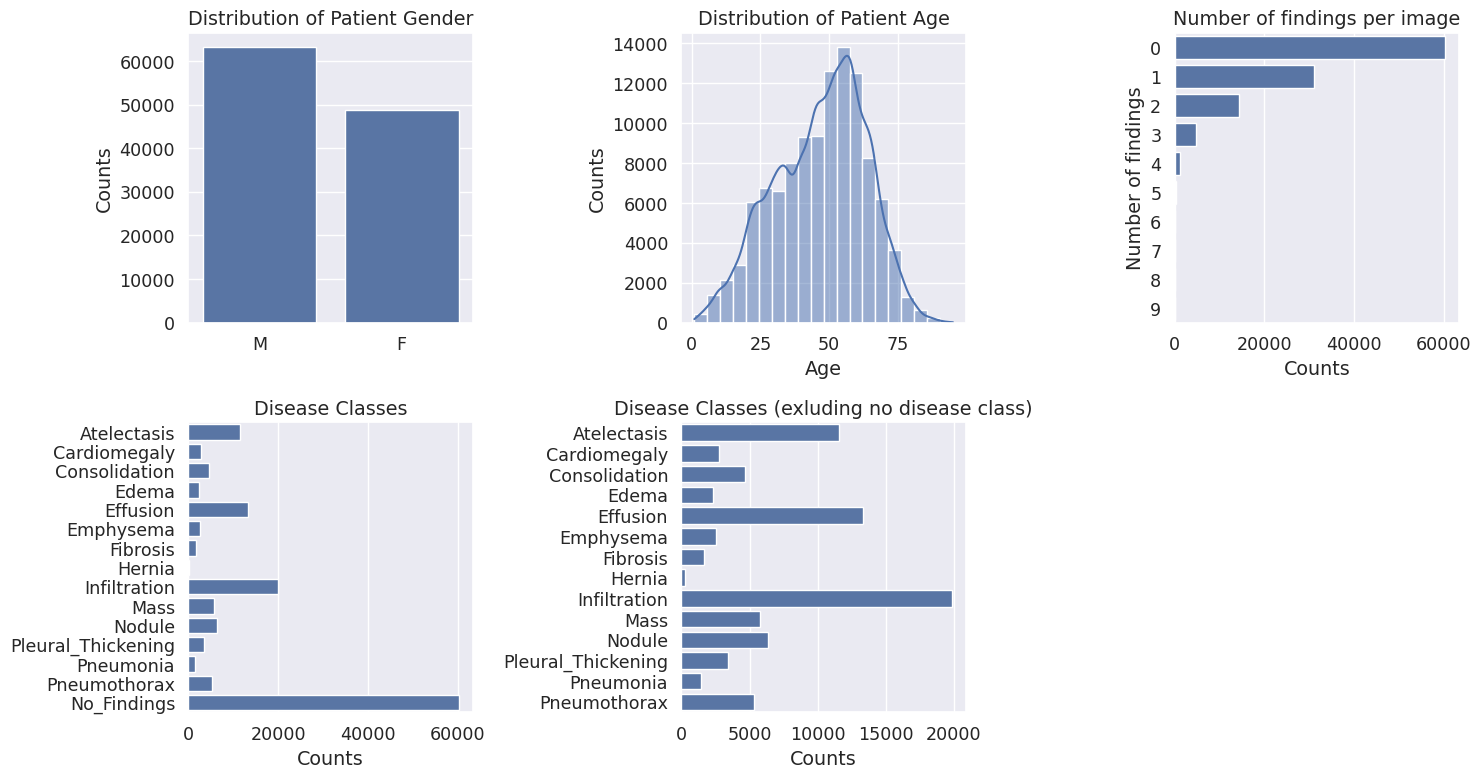

In [4]:
GOLDEN = (1 + 5**0.5) / 2
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")

plt.subplot(2, 3, 2)
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")

# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8
for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

plt.subplot(2, 3, 3)
sns.barplot(data.iloc[:, 11:-1].sum(axis=1).value_counts(), orient="h")
plt.gca().set(title="Number of findings per image", xlabel="Counts", ylabel="Number of findings")

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

plt.subplot(2, 3, 4)
sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)

plt.subplot(2, 3, 5)
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

###### remove calculated columns


In [5]:
data = data[column_names]

## Analyze prompts and responses


###### import results


In [6]:
# filelist = [x.as_posix() for x in Path("output").rglob("disease_classification_QA*.csv")]
filelist = [x.as_posix() for x in Path("output").rglob("CheXagent_results_on_NIH_CXR.csv.gz")]
results = pd.DataFrame()
for f in filelist:
    df_i = pd.read_csv(f, usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str)
    results = pd.concat([results, df_i])

results = results.drop_duplicates(ignore_index=True)
results["n_labels"] = results["finding_labels"].transform(count_substrings)
results = results[["image_index", "finding_labels", "n_labels", "prompt_key", "response"]]

disp_df(results)

,image_index,finding_labels,n_labels,prompt_key,response
0,00007109_020.png,Fibrosis|Pneumonia,2,11,Atelectasis
1,00007109_020.png,Fibrosis|Pneumonia,2,12,"Atelectasis, Infiltration"
2,00007109_020.png,Fibrosis|Pneumonia,2,13,"A) 'Atelectasis', B) 'Cardiomegaly', C) 'Conso..."
3,00007109_020.png,Fibrosis|Pneumonia,2,14,"L) 'Pleural_Thickening', M) 'Pneumonia'"
4,00007109_020.png,Fibrosis|Pneumonia,2,15,I) 'Infiltration'


nRows: 1,114,710        nColumns: 5

###### analyze response strings


In [7]:
results["response_num_findings"] = results["response"].transform(count_substrings)
results["response_num_findings_grouped"] = results["response_num_findings"].apply(lambda x: 15 if x >= 15 else x)
results["label_in_response"] = results.apply(is_label_in_response, axis=1)
results["true_positives"] = results.apply(true_positives, axis=1)
results["true_positives_len"] = results["true_positives"].transform(len)
results["false_positives"] = results.apply(false_positives, axis=1)
results["false_positives_len"] = results["false_positives"].transform(len)
results["true_negatives"] = results.apply(true_negatives, axis=1)
results["true_negatives_len"] = results["true_negatives"].transform(len)
results["false_negatives"] = results.apply(false_negatives, axis=1)
results["false_negatives_len"] = results["false_negatives"].transform(len)

results["accuracy"] = (results["true_positives_len"] + results["true_negatives_len"]) / 15
results["recall"] = results["true_positives_len"] / (results["true_positives_len"] + results["false_negatives_len"])
results["precision"] = results["true_positives_len"] / (results["true_positives_len"] + results["false_positives_len"])
results["f1"] = (2 * ((results["precision"] * results["recall"]) / (results["precision"] + results["recall"]))).fillna(
    0.0
)
results["specificity"] = results["true_negatives_len"] / (
    results["true_negatives_len"] + results["false_positives_len"]
)

disp_df(results)

,image_index,finding_labels,n_labels,prompt_key,response,response_num_findings,response_num_findings_grouped,label_in_response,true_positives,true_positives_len,...,false_positives_len,true_negatives,true_negatives_len,false_negatives,false_negatives_len,accuracy,recall,precision,f1,specificity
0,00007109_020.png,Fibrosis|Pneumonia,2,11,Atelectasis,1,1,False,[],0,...,1,"[Cardiomegaly, Consolidation, Edema, Effusion,...",14,"[Fibrosis, Pneumonia]",2,0.933333,0.0,0.000000,0.000000,0.933333
1,00007109_020.png,Fibrosis|Pneumonia,2,12,"Atelectasis, Infiltration",2,2,False,[],0,...,2,"[Cardiomegaly, Consolidation, Edema, Effusion,...",13,"[Fibrosis, Pneumonia]",2,0.866667,0.0,0.000000,0.000000,0.866667
2,00007109_020.png,Fibrosis|Pneumonia,2,13,"A) 'Atelectasis', B) 'Cardiomegaly', C) 'Conso...",11,11,False,"[Fibrosis, Pneumonia]",2,...,9,"[Hernia, Mass, Pneumothorax, No Finding]",4,[],0,0.400000,1.0,0.181818,0.307692,0.307692
3,00007109_020.png,Fibrosis|Pneumonia,2,14,"L) 'Pleural_Thickening', M) 'Pneumonia'",2,2,False,[Pneumonia],1,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",13,[Fibrosis],1,0.933333,0.5,0.500000,0.500000,0.928571
4,00007109_020.png,Fibrosis|Pneumonia,2,15,I) 'Infiltration',1,1,False,[],0,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",14,"[Fibrosis, Pneumonia]",2,0.933333,0.0,0.000000,0.000000,0.933333


nRows: 1,114,710        nColumns: 21

In [8]:
# remove outlier case
# results = results.loc[results["response_num_findings"] != 0, :]

###### make categorical columns


In [8]:
# make "prompt_key" categorical
prompt_file_list = Path("data").glob("prompts*")
prompts = {}
for prompt_file in prompt_file_list:
    with open(prompt_file.as_posix(), "r") as json_file:
        data = json.load(json_file)
        prompts.update(data)

prompt_key_order = [int(key) for key in prompts.keys()]
prompt_key_order.sort()
prompt_key_order = [str(key) for key in prompt_key_order]

results["prompt_key"] = pd.Categorical(results["prompt_key"], ordered=True, categories=prompt_key_order)

# make "findings_label" categorical
# findings_label_order = ["No Finding", "Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "Mass", "Emphysema", "Fibrosis", "Consolidation", "Cardiomegaly", "Edema", "Pleural_Thickening", "Pneumonia", "Hernia"]  # fmt: skip # nopep8
# results["finding_labels"] = pd.Categorical(results["finding_labels"], ordered=True, categories=findings_label_order)

In [9]:
# make response_num_findings_grouped, and make categorical
response_num_findings_grouped_order = results["response_num_findings_grouped"].drop_duplicates().sort_values().values
results["response_num_findings_grouped"] = pd.Categorical(
    results["response_num_findings_grouped"], ordered=True, categories=response_num_findings_grouped_order
)

display(results.dtypes)

image_index                        object
finding_labels                     object
n_labels                            int64
prompt_key                       category
response                           object
response_num_findings               int64
response_num_findings_grouped    category
label_in_response                    bool
true_positives                     object
true_positives_len                  int64
false_positives                    object
false_positives_len                 int64
true_negatives                     object
true_negatives_len                  int64
false_negatives                    object
false_negatives_len                 int64
accuracy                          float64
recall                            float64
precision                         float64
f1                                float64
specificity                       float64
dtype: object

#### Evaluate MLC task of the different prompts

[Comprehensive comparative study of multi-label classification methods](https://doi.org/10.1016/j.eswa.2022.117215)

4.5 Statistical evaluation if performance of the methods are statisitically significant:

- corrected Friedman test (non-parametric multiple hypothesis test)
- post-hoc Nemenyi test


##### Findings: Three or more


In [268]:
# load prompts used three or more findings
with open("data/prompts_three_or_more_findings.json", "r") as json_file:
    prompts = json.load(json_file)

# subset results
df_res = results[results["prompt_key"] == "1"].copy()

disp_df(df_res)

,image_index,finding_labels,n_labels,prompt_key,response,response_num_findings,response_num_findings_grouped,label_in_response,true_positives,true_positives_len,...,false_positives_len,true_negatives,true_negatives_len,false_negatives,false_negatives_len,accuracy,recall,precision,f1,specificity
143060,00001582_019.png,Pneumonia,1,1,No Finding,1,1,False,[],0,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",14,[Pneumonia],1,0.933333,0.0,0.0,0.0,0.933333
143061,00001582_020.png,Effusion,1,1,No Finding,1,1,False,[],0,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",14,[Effusion],1,0.933333,0.0,0.0,0.0,0.933333
143062,00001582_021.png,Pneumonia,1,1,No Finding,1,1,False,[],0,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",14,[Pneumonia],1,0.933333,0.0,0.0,0.0,0.933333
143063,00001583_002.png,Emphysema,1,1,No Finding,1,1,False,[],0,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",14,[Emphysema],1,0.933333,0.0,0.0,0.0,0.933333
143064,00001583_003.png,Pneumothorax,1,1,No Finding,1,1,False,[],0,...,1,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",14,[Pneumothorax],1,0.933333,0.0,0.0,0.0,0.933333


nRows: 91,324   nColumns: 21

In [269]:
y_true = df_res["finding_labels"].str.split("|")
y_pred = df_res["true_positives"] + df_res["false_positives"]
classes = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8
mlb = MultiLabelBinarizer(classes=classes)
ytrue = mlb.fit_transform(y_true)
ypred = mlb.fit_transform(y_pred)

display(pd.DataFrame({"y_true": mlb.inverse_transform(ytrue), "y_pred": mlb.inverse_transform(ypred)}))

,y_true,y_pred
0,"(Pneumonia,)","(No Finding,)"
1,"(Effusion,)","(No Finding,)"
2,"(Pneumonia,)","(No Finding,)"
3,"(Emphysema,)","(No Finding,)"
4,"(Pneumothorax,)","(No Finding,)"
...,...,...
91319,"(No Finding,)","(No Finding,)"
91320,"(No Finding,)","(No Finding,)"
91321,"(No Finding,)","(No Finding,)"
91322,"(No Finding,)","(No Finding,)"


###### Determine `scikit-learn` metric params

In [270]:
# Isolate one particular label and analyze one binary case
true_0, pred_0 = ytrue[:, 0], ypred[:, 0]
temp = pd.DataFrame({"true": ytrue[:, 0], "pred": ypred[:, 0]})

temp["true_pos"] = 0.
temp.loc[(temp["true"] == 1) & (temp["pred"] == 1), "true_pos"] = 1

temp["true_neg"] = 0.
temp.loc[(temp["true"] == 0) & (temp["pred"] == 0), "true_neg"] = 1

temp["false_pos"] = 0.
temp.loc[(temp["true"] == 0) & (temp["pred"] == 1), "false_pos"] = 1

temp["false_neg"] = 0.
temp.loc[(temp["true"] == 1) & (temp["pred"] == 0), "false_neg"] = 1

disp_df(temp)

val_binary = recall_score(true_0, pred_0, average="binary", zero_division=0.0)
val_micro = recall_score(true_0, pred_0, average="micro", zero_division=0.0)
val_macro = recall_score(true_0, pred_0, average="macro", zero_division=0.0)
print(f"recall(avg='binary'): {val_binary}")
print(f"recall(avg='micro' or 'weighted'): {val_micro}")
print(f"recall(avg='macro'): {val_macro}")

# this matches average = "binary"
val = temp["true_pos"].sum() / (temp["true_pos"].sum() + temp["false_neg"].sum())
print(f"replicate metric for avg='binary': {val}")

# this matches average = "micro" or "weighted"
val = (temp["true_pos"].sum() + temp["true_neg"].sum()) / temp.shape[0]
print(f"replicate metric for avg='micro' or 'weighted': {val}")

# this matches average = "macro"
val = recall_score(true_0, pred_0, average=None, zero_division=0.0).mean()
print(f"replicate metric for avg='macro': {val}")

,true,pred,true_pos,true_neg,false_pos,false_neg
0,0,0,0.0,1.0,0.0,0.0
1,0,0,0.0,1.0,0.0,0.0
2,0,0,0.0,1.0,0.0,0.0
3,0,0,0.0,1.0,0.0,0.0
4,0,0,0.0,1.0,0.0,0.0


nRows: 91,324   nColumns: 6

recall(avg='binary'): 0.012574139976275208

recall(avg='micro' or 'weighted'): 0.94629013183829

recall(avg='macro'): 0.5020222982653535

replicate metric for avg='binary': 0.012574139976275208

replicate metric for avg='micro' or 'weighted': 0.94629013183829

replicate metric for avg='macro': 0.5020222982653535

In [271]:
metrics_wide = compute_mlc_metrics_wide(df_res)
metrics = compute_mlc_metrics(df_res)
display(metrics_wide)
display(metrics)

,zerodiv,metric,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,0,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.0,0.0,0.0,0.016751,0.032200,0.002199,0.0,0.015000,0.006352,0.796219
1,1,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.0,0.0,0.0,0.016751,0.032200,0.002199,0.0,0.015000,0.006352,0.796219
2,nan,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.0,0.0,0.0,0.016751,0.032200,0.002199,0.0,0.015000,0.006352,0.796219
3,0,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.0,0.0,0.0,0.008446,0.016364,0.001101,0.0,0.007557,0.003186,0.661432
4,1,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.0,0.0,0.0,0.008446,0.016364,0.001101,0.0,0.007557,0.003186,0.661432
5,nan,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.0,0.0,0.0,0.008446,0.016364,0.001101,0.0,0.007557,0.003186,0.661432
6,0,precision,0.066583,0.064478,0.078541,0.015267,0.328449,0.0,0.0,0.0,0.174274,0.371134,0.130435,0.0,0.038462,0.700000,0.666734
7,1,precision,0.066583,0.064478,0.078541,0.015267,0.328449,0.0,0.0,1.0,0.174274,0.371134,0.130435,0.0,0.038462,0.700000,0.666734
8,nan,precision,0.066583,0.064478,0.078541,0.015267,0.328449,0.0,0.0,NaN,0.174274,0.371134,0.130435,0.0,0.038462,0.700000,0.666734
9,0,recall,0.012574,0.050320,0.096947,0.009554,0.068015,0.0,0.0,0.0,0.008799,0.016830,0.001109,0.0,0.009317,0.003191,0.988121


,avg_opt,zerodiv_opt,accuracy,hammingloss,jaccard,precision,recall,f1
0,macro,0,0.654253,0.047746,0.056589,0.175624,0.084318,0.077175
1,macro,1,0.654253,0.047746,0.056589,0.24229,0.084318,0.077175
2,macro,nan,0.654253,0.047746,0.056589,0.188168,0.084318,0.077175
3,weighted,0,0.654253,0.047746,0.442697,0.507709,0.660144,0.5369
4,weighted,1,0.654253,0.047746,0.442697,0.508913,0.660144,0.5369
5,weighted,nan,0.654253,0.047746,0.442697,0.508321,0.660144,0.5369
6,micro,0,0.654253,0.047746,0.479641,0.636913,0.660144,0.648321
7,micro,1,0.654253,0.047746,0.479641,0.636913,0.660144,0.648321
8,micro,nan,0.654253,0.047746,0.479641,0.636913,0.660144,0.648321
9,samples,0,0.654253,0.047746,0.655824,0.655824,0.660144,0.656683


In [266]:
prompt_keys = results["prompt_key"].unique()

df_agg_wide = pd.DataFrame()
df_agg = pd.DataFrame()
for prompt_key in prompt_keys[:3]:
    df_input = results[results["prompt_key"] == prompt_key].copy()
    
    metrics_wide_i = compute_mlc_metrics_wide(df_input)    
    metrics_wide_i["prompt_key"] = prompt_key    
    df_agg_wide = pd.concat([df_agg_wide, metrics_wide_i], ignore_index=True)
    
    metrics_i = compute_mlc_metrics(df_input)    
    metrics_i["prompt_key"] = prompt_key    
    df_agg = pd.concat([df_agg, metrics_i], ignore_index=True)

display(df_agg_wide)
display(df_agg)

,zerodiv,metric,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding,prompt_key
0,0,f1,0.446775,0.315032,0.272545,0.234523,0.358946,0.133739,0.024883,0.000000,0.560616,0.080329,0.063113,0.228498,0.009677,0.189434,0.0,11
1,1,f1,0.446775,0.315032,0.272545,0.234523,0.358946,0.133739,0.024883,0.000000,0.560616,0.080329,0.063113,0.228498,0.009677,0.189434,0.0,11
2,nan,f1,0.446775,0.315032,0.272545,0.234523,0.358946,0.133739,0.024883,0.000000,0.560616,0.080329,0.063113,0.228498,0.009677,0.189434,0.0,11
3,0,jaccard,0.287643,0.186966,0.157772,0.132838,0.218729,0.071661,0.012598,0.000000,0.389483,0.041845,0.032585,0.128986,0.004862,0.104627,0.0,11
4,1,jaccard,0.287643,0.186966,0.157772,0.132838,0.218729,0.071661,0.012598,0.000000,0.389483,0.041845,0.032585,0.128986,0.004862,0.104627,0.0,11
5,nan,jaccard,0.287643,0.186966,0.157772,0.132838,0.218729,0.071661,0.012598,0.000000,0.389483,0.041845,0.032585,0.128986,0.004862,0.104627,0.0,11
6,0,precision,0.380701,0.220034,0.173850,0.172377,0.677842,0.666667,0.163265,0.000000,0.562132,0.514620,0.740000,0.150847,0.039474,0.683849,0.0,11
7,1,precision,0.380701,0.220034,0.173850,0.172377,0.677842,0.666667,0.163265,1.000000,0.562132,0.514620,0.740000,0.150847,0.039474,0.683849,0.0,11
8,nan,precision,0.380701,0.220034,0.173850,0.172377,0.677842,0.666667,0.163265,NaN,0.562132,0.514620,0.740000,0.150847,0.039474,0.683849,0.0,11
9,0,recall,0.540599,0.554382,0.630447,0.366743,0.244105,0.074324,0.013468,0.000000,0.559107,0.043564,0.032962,0.470899,0.005515,0.109945,0.0,11


,avg_opt,zerodiv_opt,accuracy,hammingloss,jaccard,precision,recall,f1,prompt_key
0,macro,0,0.024186,0.175241,0.11804,0.343044,0.243071,0.194541,11
1,macro,1,0.024186,0.175241,0.11804,0.409711,0.309737,0.194541,11
2,macro,nan,0.024186,0.175241,0.11804,0.367547,0.260433,0.194541,11
3,weighted,0,0.024186,0.175241,0.207717,0.496286,0.348385,0.325461,11
4,weighted,1,0.024186,0.175241,0.207717,0.498837,0.348385,0.325461,11
5,weighted,nan,0.024186,0.175241,0.207717,0.497555,0.348385,0.325461,11
6,micro,0,0.024186,0.175241,0.209531,0.344568,0.348385,0.346466,11
7,micro,1,0.024186,0.175241,0.209531,0.344568,0.348385,0.346466,11
8,micro,nan,0.024186,0.175241,0.209531,0.344568,0.348385,0.346466,11
9,samples,0,0.024186,0.175241,0.230666,0.345223,0.348385,0.316012,11


In [296]:
plotdf = df_agg_wide[df_agg_wide["zerodiv"] == "nan"].drop(columns=["zerodiv"]).melt(id_vars=["metric", "prompt_key"], var_name="finding_labels")
disp_df(plotdf)

,metric,prompt_key,finding_labels,value
0,f1,11,Atelectasis,0.446775
1,jaccard,11,Atelectasis,0.287643
2,precision,11,Atelectasis,0.380701
3,recall,11,Atelectasis,0.540599
4,f1,12,Atelectasis,0.473633


nRows: 180      nColumns: 4

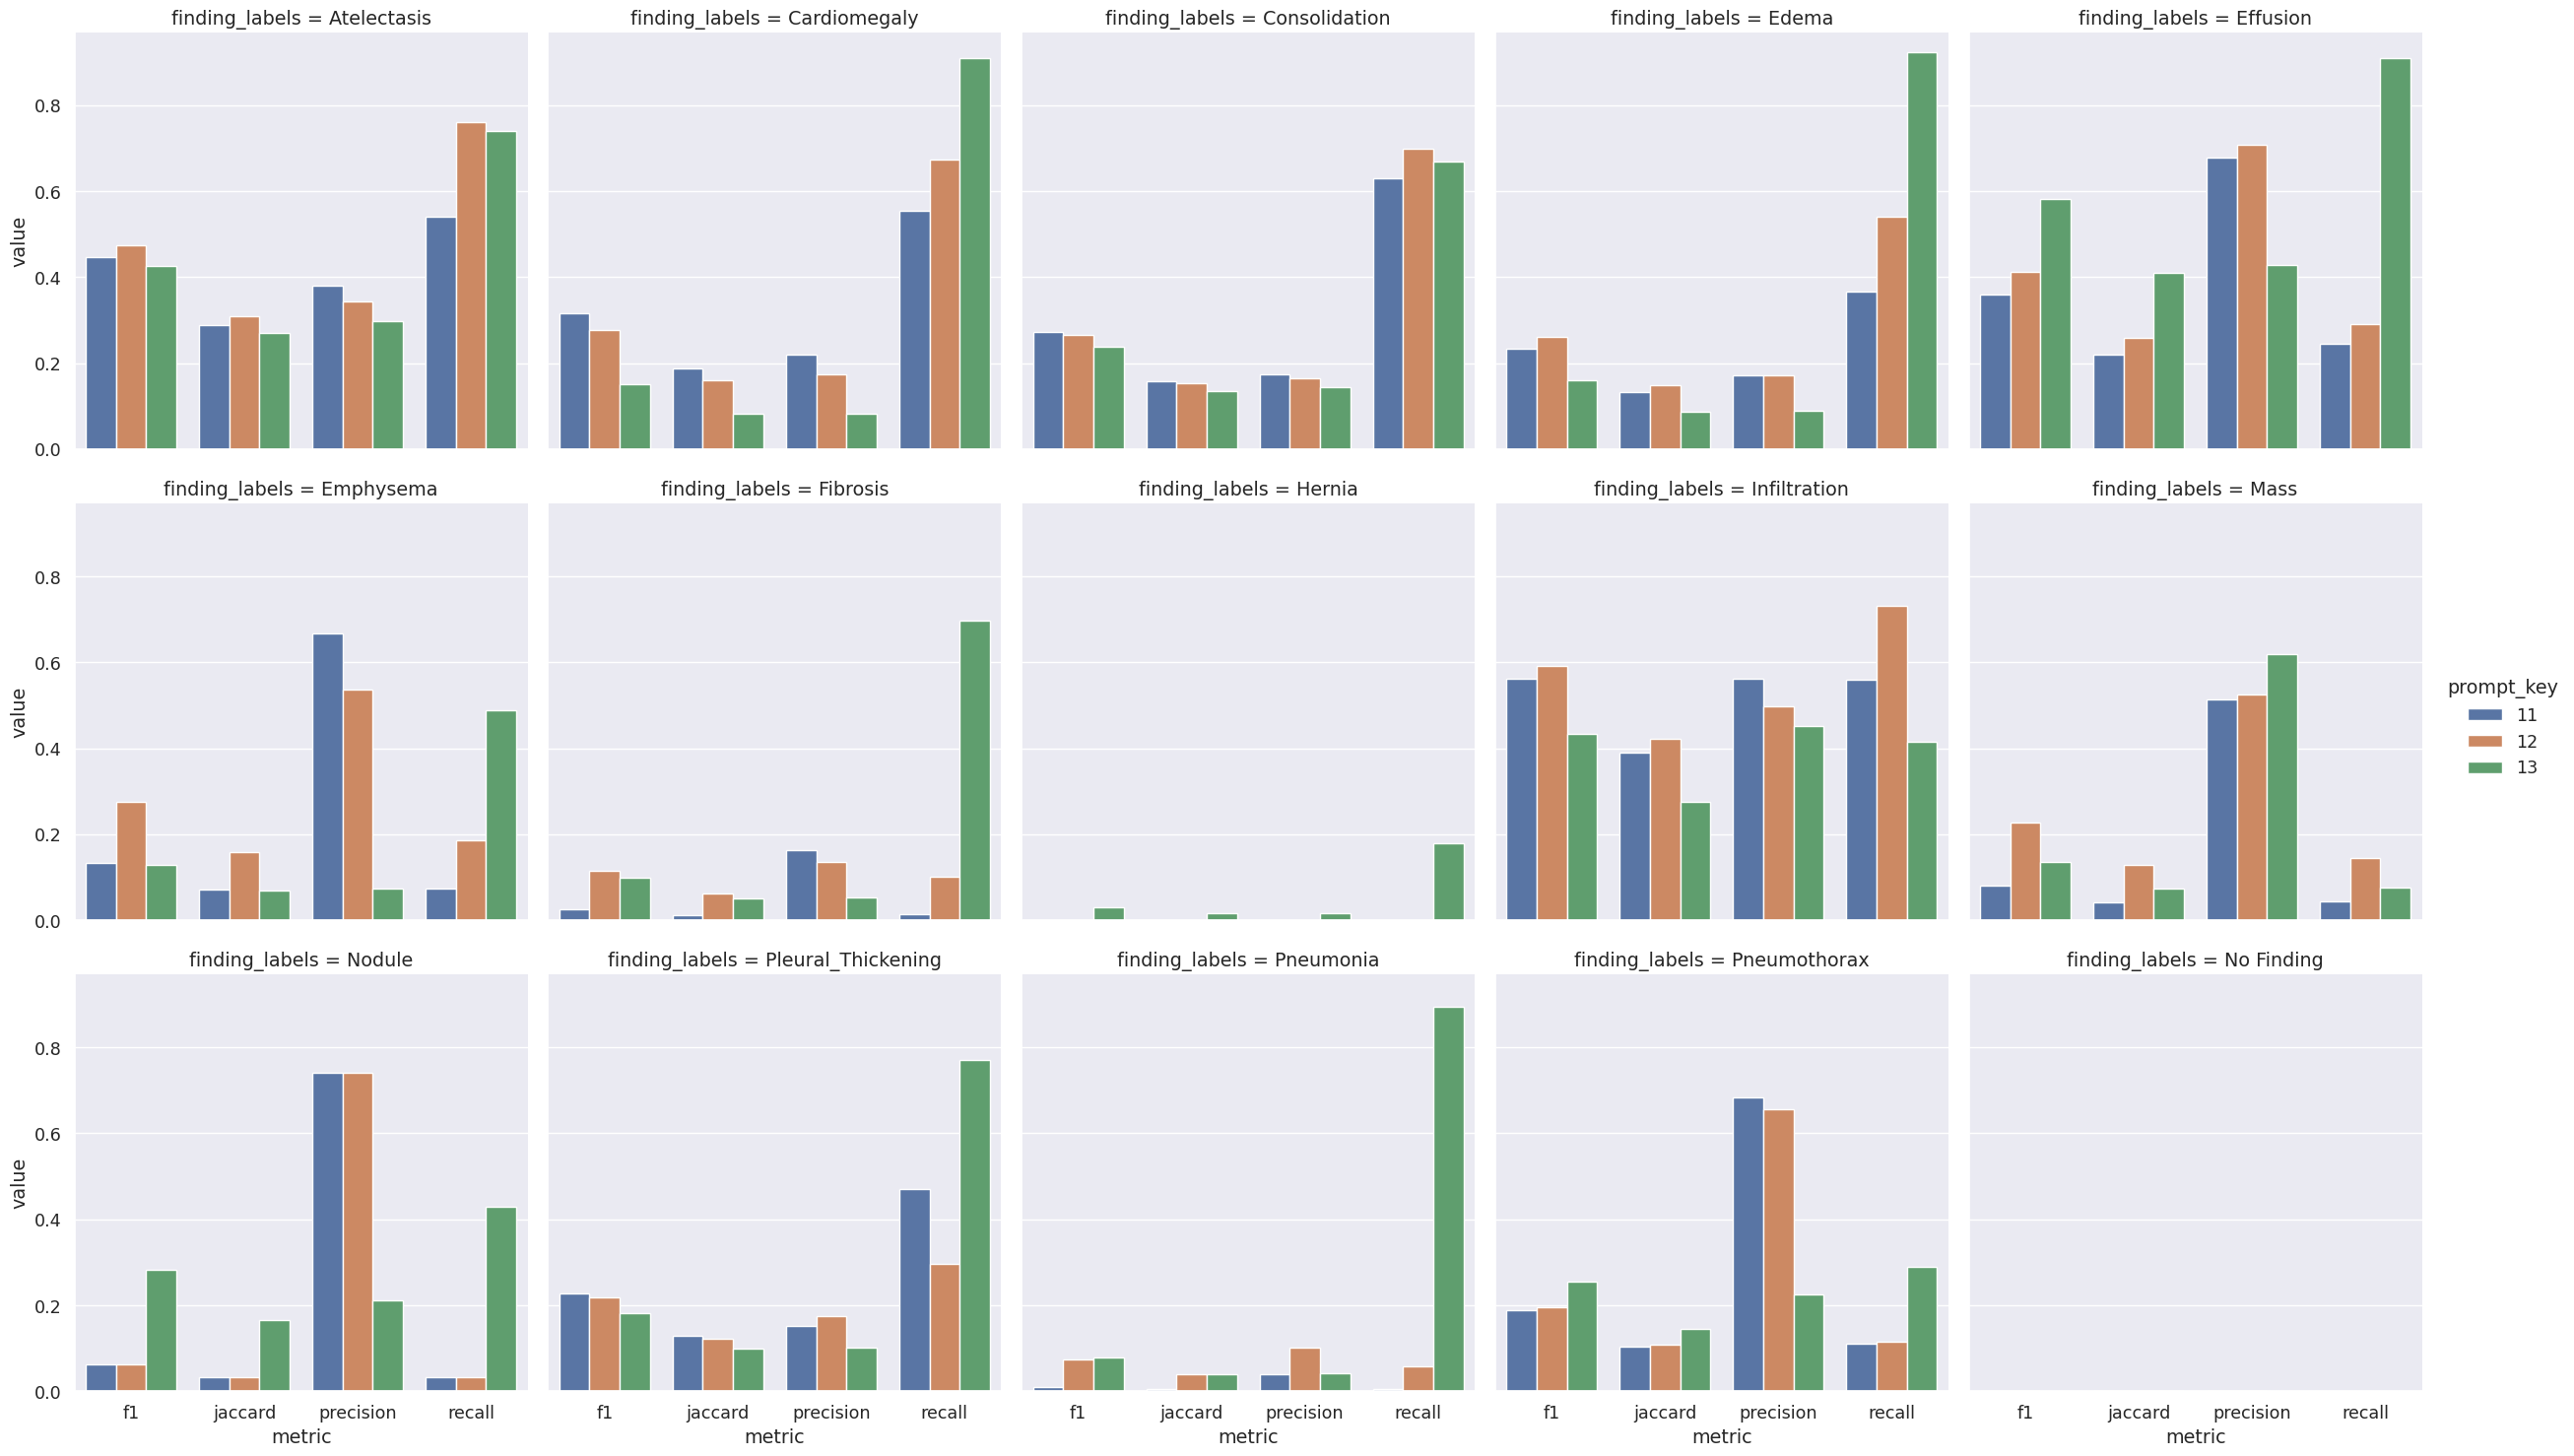

In [301]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.catplot(
    data=plotdf,
    x="metric",
    y="value",
    kind="bar",
    hue="prompt_key",
    col="finding_labels",
    col_wrap=5
)

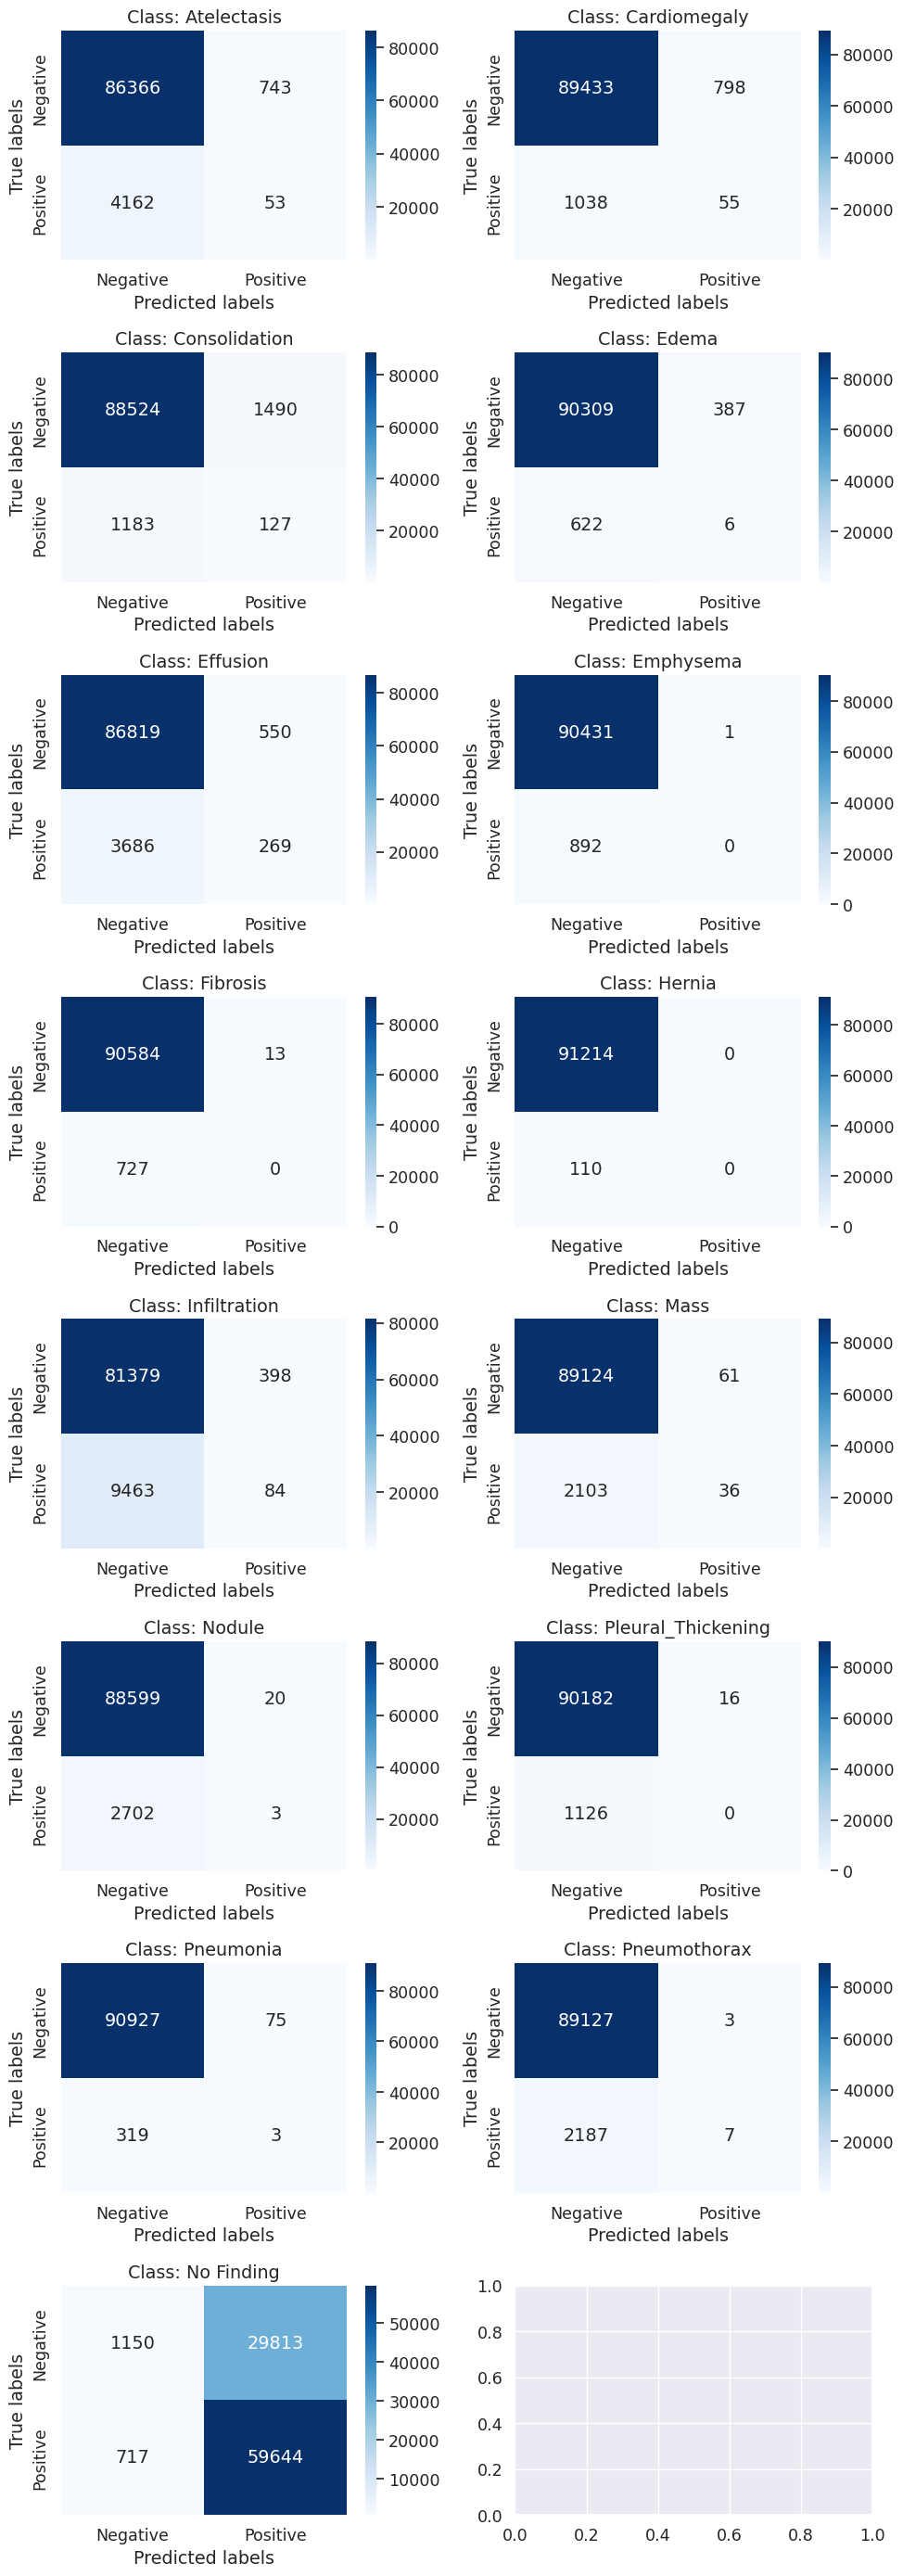

In [273]:
# Compute confusion matrices for each class
mcm = multilabel_confusion_matrix(ytrue, ypred)


# Function to plot confusion matrices for each class
def plot_multilabel_confusion_matrix(mcm, classes):
    fig, axes = plt.subplots(
        nrows=int(len(classes) / 2) + len(classes) % 2, ncols=2, figsize=(10, 4 * int(len(classes) / 2))
    )
    for i, (cm, class_name) in enumerate(zip(mcm, classes)):
        ax = axes.flatten()[i]
        sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(f"Class: {class_name}")
        ax.xaxis.set_ticklabels(["Negative", "Positive"])
        ax.yaxis.set_ticklabels(["Negative", "Positive"])

    plt.tight_layout()
    plt.show()


# Plotting the confusion matrices
plot_multilabel_confusion_matrix(mcm, mlb.classes_)

#### Plots


##### Confusion matrix


In [275]:
conf_matrices = {label: {"TP": 0, "FP": 0, "TN": 0, "FN": 0} for label in classes}


def update_conf_matrix(row, label):
    if label in row["true_positives"]:
        conf_matrices[label]["TP"] += 1
    if label in row["false_positives"]:
        conf_matrices[label]["FP"] += 1
    if label in row["true_negatives"]:
        conf_matrices[label]["TN"] += 1
    if label in row["false_negatives"]:
        conf_matrices[label]["FN"] += 1


for label in classes:
    results.apply(lambda row: update_conf_matrix(row, label), axis=1)


conf_matrices

{'Atelectasis': {'TP': 59056, 'FP': 326866, 'TN': 728788, 'FN': 53328},
 'Cardiomegaly': {'TP': 12455, 'FP': 169883, 'TN': 932372, 'FN': 14569},
 'Consolidation': {'TP': 15296, 'FP': 146110, 'TN': 953304, 'FN': 29738},
 'Edema': {'TP': 11923, 'FP': 190146, 'TN': 912641, 'FN': 10310},
 'Effusion': {'TP': 71753, 'FP': 175642, 'TN': 867315, 'FN': 57356},
 'Emphysema': {'TP': 5749, 'FP': 127932, 'TN': 981029, 'FN': 18675},
 'Fibrosis': {'TP': 3979, 'FP': 135450, 'TN': 975281, 'FN': 12516},
 'Hernia': {'TP': 128, 'FP': 59916, 'TN': 1054666, 'FN': 2098},
 'Infiltration': {'TP': 32673, 'FP': 101140, 'TN': 980897, 'FN': 162239},
 'Mass': {'TP': 2976, 'FP': 55721, 'TN': 1056013, 'FN': 53221},
 'Nodule': {'TP': 6224, 'FP': 85819, 'TN': 1022667, 'FN': 55705},
 'Pleural_Thickening': {'TP': 14353, 'FP': 269567, 'TN': 830790, 'FN': 18372},
 'Pneumonia': {'TP': 6647, 'FP': 299496, 'TN': 808567, 'FN': 7098},
 'Pneumothorax': {'TP': 8551, 'FP': 93504, 'TN': 1012655, 'FN': 43171},
 'No Finding': {'TP': 

In [ ]:
sns.set_theme(style="white")

for label, matrix in conf_matrices.items():
    cm = np.array([[matrix["TP"], matrix["FP"]], [matrix["FN"], matrix["TN"]]])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

##### Histogram on `response_num_findings`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="prompt_key",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="prompt_key",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Share of no. of findings within generated response by prompt")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="finding_labels",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Share of no. of findings within generated response by GT label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    # palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    palette="tab20",
)

g.set_axis_labels(x_var="Resp. number of findings")
g.legend.set_title("Finding")
g.tight_layout()
plt.show()

##### Histogram on `prompt_key`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Is label in generated response?")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Share of generated responses with correct label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="response_num_findings_grouped",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(0.85, 0.5), title="No. labels\nin response")
g.figure.suptitle("Share of number of findings within generated response by prompt")
g.tight_layout()
plt.show()

##### Heatmaps


In [ ]:
sns.set_theme(style="white")

plotdf = (
    results.groupby(["prompt_key", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="prompt_key", index="response_num_findings", values=0)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".0f")
ax.set(title="Number of findings in response by prompt", xlabel="Prompt Key", ylabel="Number of findings in response")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="white", font_scale=1)

plotdf = (
    results.groupby(["finding_labels", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="finding_labels", index="response_num_findings", values=0)
    .transform(lambda x: (x / x.sum()) * 100)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 8, 8))
ax = sns.heatmap(plotdf, annot=True, fmt=".1f")
ax.set(
    title="Number of findings in response by disease\n(values are percentages, columns sum to 100%)",
    xlabel="Disease",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Multi-finding imags


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.relplot(
    data=results,
    x="response_num_findings_grouped",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

## Getting started with `scikit-multilearn`


In [1]:
from skmultilearn.dataset import load_dataset

In [2]:
X_train, y_train, feature_names, label_names = load_dataset("emotions", "train")
X_test, y_test, _, _ = load_dataset("emotions", "test")

emotions:train - does not exists downloading
Downloaded emotions-train
emotions:test - does not exists downloading
Downloaded emotions-test


In [3]:
feature_names[:10]

[('Mean_Acc1298_Mean_Mem40_Centroid', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Rolloff', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Flux', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_0', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_1', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_2', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_3', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_4', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_5', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_6', 'NUMERIC')]

In [4]:
label_names

[('amazed-suprised', ['0', '1']),
 ('happy-pleased', ['0', '1']),
 ('relaxing-calm', ['0', '1']),
 ('quiet-still', ['0', '1']),
 ('sad-lonely', ['0', '1']),
 ('angry-aggresive', ['0', '1'])]

In [5]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

In [6]:
clf = BinaryRelevance(classifier=SVC(), require_dense=[False, True])

In [7]:
clf.classifiers

AttributeError: 'BinaryRelevance' object has no attribute 'classifiers'

In [8]:
clf.fit(X_train, y_train)

BinaryRelevance(classifier=SVC(), require_dense=[False, True])

In [9]:
clf.classifiers

AttributeError: 'BinaryRelevance' object has no attribute 'classifiers'

In [ ]:
prediction = clf.predict(X_test)

In [ ]:
prediction

### Measure the quality


In [ ]:
import sklearn.metrics as metrics

In [ ]:
metrics.hamming_loss(y_test, prediction)

In [ ]:
metrics.accuracy_score(y_test, prediction)